In [0]:
%tensorflow_version 2.x
import tensorflow as tf

# layers
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Concatenate
# model, since we have parallel input units, that kind of architecture is not supported by Sequential model API. So I'll use functional API
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import SGD, Adam
# additional imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:
# dataset source : https://grouplens.org/datasets/book-crossing/
!wget -nc http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip

File ‘BX-CSV-Dump.zip’ already there; not retrieving.



In [0]:
!unzip -n BX-CSV-Dump.zip

Archive:  BX-CSV-Dump.zip


In [0]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding = 'ISO-8859-1', error_bad_lines = False)
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = 'ISO-8859-1')
users = pd.read_csv('BX-Users.csv', sep=';', encoding = 'ISO-8859-1')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

# Preprocessing
I took a look at all the dataframes but only usable one is "ratings" dataset.
There's no need to preprocess the data actually, I'll just correct the indexing and then we're okay.

In [0]:
# Redo the indexing with pandas | TODO: Do it manually
# index user ids again
ratings['User-ID'] = pd.Categorical(ratings['User-ID'])
ratings['New-User-ID'] = ratings['User-ID'].cat.codes
# now for ISBNs
ratings['ISBN'] = pd.Categorical(ratings['ISBN'])
ratings['New-Book-Index'] = ratings['ISBN'].cat.codes

In [0]:
# Now we can drop the old user id and isbn columns
ratings = ratings.drop(['User-ID', 'ISBN'], axis = 1)
ratings.head()

,Book-Rating,New-User-ID,New-Book-Index
0,0,104433,57188
1,5,104434,29750
2,0,104435,107392
3,3,104436,127253
4,6,104436,127287


In [0]:
# Seperate the dataset
book_ratings = ratings['Book-Rating'].values
book_indexes = ratings['New-Book-Index'].values
user_ids = ratings['New-User-ID'].values

In [0]:
# Get the total user and book numbers
N = len(set(user_ids))
B = len(set(book_indexes))
# Set embedding dimension
K = 20 # hyperparameter
print('Number of users is {} and number of books is {}'.format(N,B))

Number of users is 105283 and number of books is 340556


In [0]:
# let's create the ANN

# since we'll have multiple inputs, we can't use the sequential api
u = Input(shape = (1,))
b = Input(shape = (1,))
#
u_emb = Embedding(N, K)(u)
b_emb = Embedding(B, K)(b)
#
u_emb = Flatten()(u_emb)
b_emb = Flatten()(b_emb)
#
x = Concatenate()([u_emb, b_emb])
#
x = Dense(2048, activation = 'relu')(x)
x = Dense(1)(x)
#
model = Model(inputs = [u,b], outputs = x )
model.compile(loss = 'mse', metrics = ['mse', 'mae'],
              optimizer = SGD(lr = 0.09, momentum = 0.8))

In [0]:
# shuffle the data
book_ratings, book_indexes, user_ids = shuffle(book_ratings, book_indexes, user_ids)
# I'll use 80% of the data for training 20% of the data for test
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_ratings = book_ratings[:Ntrain]
train_indexes = book_indexes[:Ntrain]
#
test_user = user_ids[Ntrain:]
test_ratings = book_ratings[Ntrain:]
test_indexes = book_indexes[Ntrain:]
# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [0]:
r = model.fit(
    x = [train_user, train_indexes],
    y = train_ratings,
    epochs = 10,
    batch_size = 512,
    verbose = 1,
    validation_data = ([test_user, test_indexes], test_ratings),
)

Epoch 1/10
1797/1797 [==============================] - 24s 13ms/step - loss: 11.9641 - mse: 11.9642 - mae: 2.8882 - val_loss: 11.4859 - val_mse: 11.4837 - val_mae: 2.7293
Epoch 2/10
1797/1797 [==============================] - 24s 14ms/step - loss: 10.9339 - mse: 10.9341 - mae: 2.6673 - val_loss: 11.4225 - val_mse: 11.4202 - val_mae: 2.7498
Epoch 3/10
1797/1797 [==============================] - 24s 14ms/step - loss: 10.0815 - mse: 10.0816 - mae: 2.4990 - val_loss: 11.6115 - val_mse: 11.6110 - val_mae: 2.7070
Epoch 4/10
1797/1797 [==============================] - 25s 14ms/step - loss: 8.6946 - mse: 8.6946 - mae: 2.2279 - val_loss: 12.1022 - val_mse: 12.1006 - val_mae: 2.6947
Epoch 5/10
1797/1797 [==============================] - 25s 14ms/step - loss: 7.3274 - mse: 7.3272 - mae: 1.9476 - val_loss: 12.8964 - val_mse: 12.8945 - val_mae: 2.7103
Epoch 6/10
1797/1797 [==============================] - 25s 14ms/step - loss: 6.3562 - mse: 6.3557 - mae: 1.7490 - val_loss: 12.9661 - val_mse: 

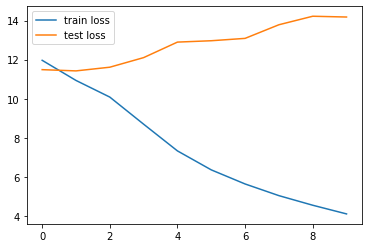

In [0]:
# plot the losses
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend()
plt.show()

In [0]:
# is this approach on par with other approaches?
# usually the score that matters is the rmse so lets take the square root of mse
print(np.sqrt(r.history['val_mse' ][-1])) # validation rmse
print(np.sqrt(r.history['mse'][-1])) # training rmse 
# as a result, we can say that our approach is on par or even better than some of the state-of-art approaches.

3.765349192035696
2.025226288384841
